In [68]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, transpile, QuantumRegister
from qiskit.circuit.library import XGate, ZGate
from qiskit_aer import Aer, AerSimulator
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram

In [69]:
num_input = 3
num_qubits = num_input * 2

In [70]:
def multi_cx(qc, controls, anti_controls, target):
    num_controls = len(controls) + len(anti_controls)
    ctrl_state = get_ctrl_state(controls, anti_controls)
    new_gate = XGate().control(num_controls, ctrl_state=ctrl_state)
    # print(f"MX: Controls: {controls}, anti_controls: {anti_controls}, target: {target}, ctrl_state: {ctrl_state}")
    
    # FIX later weird thing, controll is first and anti is second because before when use of x, opposite in z thing.
    sorted_controls = sorted(controls + anti_controls)
    qc.append(new_gate, sorted_controls + [target])
    
    return qc

In [71]:
def multi_cz(qc, controls, anti_controls, target):
    num_controls = len(controls) + len(anti_controls)
    ctrl_state = get_ctrl_state(controls, anti_controls)
    new_gate = ZGate().control(num_controls, label=None, ctrl_state=ctrl_state)
    # new_gate = XGate().control(num_controls, label=None, ctrl_state=ctrl_state)
    # print(f"MZ: Controls: {controls}, anti_controls: {anti_controls}, target: {target}, ctrl_state: {ctrl_state}")
    
    sorted_controls = sorted(controls + anti_controls)
    qc.append(new_gate, sorted_controls + [target])
    
    
    return qc

In [72]:
def get_ctrl_state(controls, anti_controls):
    # num_controls = len(controls) + len(anti_controls)
    ctrl_state = ''
    for i in range(num_qubits - 1, -1, -1):
        if i in controls:
            ctrl_state += '1'
        elif i in anti_controls:
            ctrl_state += '0'
    return ctrl_state

In [73]:
def L_op(qc, qubits_to_rot, num_input, ls):
    for i in range(qubits_to_rot):
        multi_cx(qc, [(qubits_to_rot - 1)], ls[i:], num_input + i)

In [74]:
def R_op(qc, qubits_to_rot, num_input, ls):
    for i in range(qubits_to_rot):
        multi_cx(qc, [(qubits_to_rot - 1)] + ls[i:], [], num_input + i)

In [75]:
def szegedy_step(qc):
    # L rotation
    ls = [num_input + i for i in range(1, num_input)]
    for i in range(num_input, 0, -1):
        # print(f"i: {i} qubits_l_op: {qubits_l_op}, ls: {ls[:(i - 1)]}")
        L_op(qc, i, num_input, ls[:(i - 1)])

    # middle part
    # for i in range(num_input - 2):
    #     multi_cx(qc, [], [num_input + 0], num_input + 1 + i)
    multi_cx(qc, [], [num_input + 0], num_input * 2 - 2)
        

    qc.h(num_input + 0) # no change

    # num_input + 1 to num_input + (num_input - 1) not included
    # multi_cz(qc, [num_input + i for i in range(1, (num_input -1))], [num_input + 0], num_input * 2 - 1) # this is as paper
    # multi_cz(qc, [num_input + 0], [num_input + i for i in range(1, (num_input -1))], num_input * 2 - 1) # this is the opposite of paper
    multi_cz(qc, [num_input + 0], [num_input * 2 - 2], num_input * 2 - 1) # this is the opposite of paper and not same at all

    qc.h(num_input + 0) # no change

    # for i in range(num_input - 2):
    #     multi_cx(qc, [], [num_input + 0], num_input + 1 + i)
    multi_cx(qc, [], [num_input + 0], num_input * 2 - 2)
    

    # R rotation
    for i in range(num_input, 0, -1):
        # print(f"i: {i} qubits_r_op: {qubits_r_op}, ls: {ls[:(i - 1)]}")
        R_op(qc, i, num_input, ls[:(i - 1)])

    for i in range(num_input-1, -1, -1):
        qc.swap(i, num_input + i)
    
    # qc.draw(output="latex_source", filename="qcircuit.tex")
    # qc.draw(output="mpl")

Printing out one step

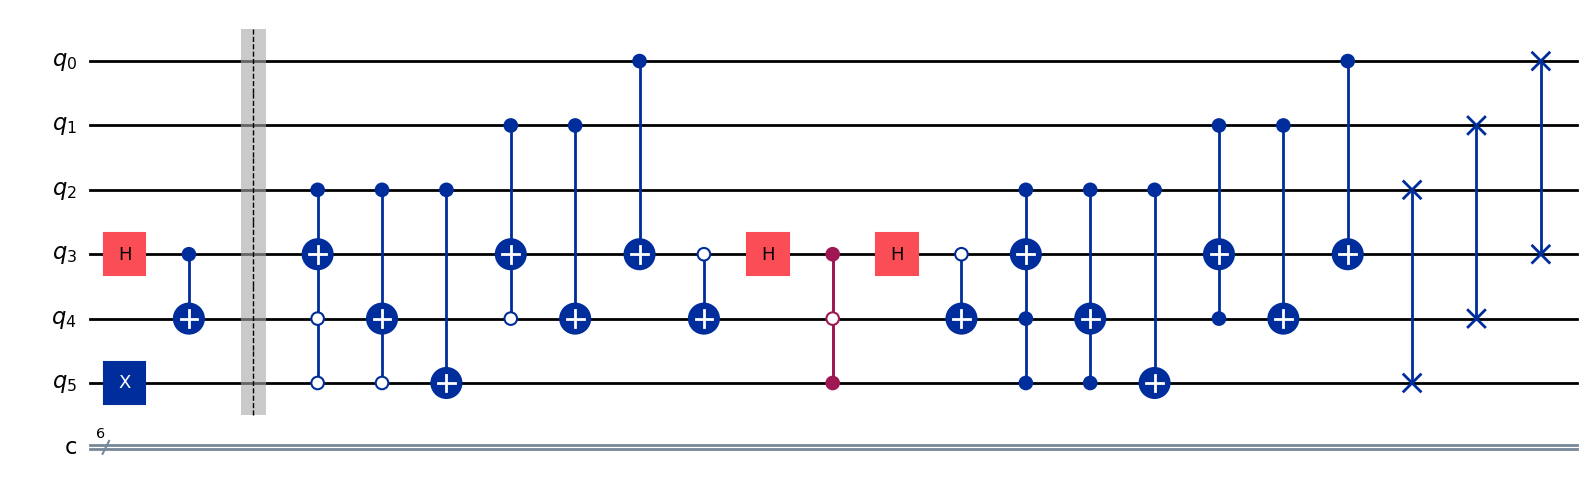

In [76]:
# Create the quantum circuit
qc = QuantumCircuit(num_input * 2, num_input * 2)

simulator = AerSimulator()

# Apply Hadamard coin operator
qc.h(num_input + 0)
for i in range(num_input - 2):
    qc.cx(num_input + 0, num_input + 1 + i)
qc.x(num_input * 2 - 1)
# done with initail setup
qc.barrier()

# states = [Statevector.from_instruction(qc)]
# print(f"Initial state: {states[0]}")
szegedy_step(qc)
qc.draw(output="mpl")


In [77]:
def calculate_values(num_input, steps):
    # Create the quantum circuit
    qc = QuantumCircuit(num_input * 2, num_input * 2)
    simulator = AerSimulator()

    # Apply Hadamard coin operator
    qc.h(num_input + 0)
    for i in range(num_input - 2):
        qc.cx(num_input + 0, num_input + 1 + i)
    qc.x(num_input * 2 - 1)
    # done with initail setup
    # qc.barrier()

    states = [Statevector.from_instruction(qc)]
    szegedy_step(qc)
    states.append(Statevector.from_instruction(qc))
    for i in range(steps-1):
        qc.h(num_input + 0)
        szegedy_step(qc)
        # print(f"Step {i+1}")
        states.append(Statevector.from_instruction(qc))

    values = []

    for i, state in enumerate(states):
        probs = state.probabilities_dict()
        
        filtered = {}
        for key, val in probs.items():
            # if val < 0.0001:
            #     continue
            pos = (key[num_input:])
            filtered[pos] = filtered.get(pos, 0) + val
        
        filtered = {k[::-1]: v for k, v in filtered.items()}
        
        sorted_keys = sorted(filtered.keys(), key=lambda x: int(x, 2))
        sorted_values = [filtered[k] for k in sorted_keys]
        
        # hardcode for first step
        if i == 0:
            sorted_values += ([0] * (2**num_input - len(sorted_values)))
            print(f"Step {i} sorted_values: {sorted_values}")
        
        values.append(sorted_values)
    
    return values
    # print(range(2**num_input), filtered.keys(), sorted_values)




In [ ]:
def plot_steps(values, max_steps):
    fig, axs = plt.subplots(3, 7, figsize=(24, 10))
    axs = axs.flatten()

    for i in range(max_steps+1):
        axs[i].bar(range(2**num_input), values[i])
        # axs[i].bar(filtered.keys(), filtered.values())
        axs[i].set_title(f"Step {i}")
        axs[i].set_ylim(0, 1)
        axs[i].set_xlabel("Position state")
        axs[i].set_ylabel("Probability")
    
    plt.tight_layout()
    plt.show()


Så man kan se stora tal för en vis step

In [79]:
def plot_step(values, step):
    print(f"eeh: {values[step]}, eeeeh: {len(values)}")
    fig, axs = plt.subplots(1, 1, figsize=(24, 10))

    axs.bar(range(2**num_input), values[step])
    # ai].bar(filtered.keys(), filtered.values())
    axs.set_title(f"Step {step}")
    axs.set_ylim(0, 1)
    axs.set_xlabel("Position state")
    axs.set_ylabel("Probability")
    
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_spectral(values, steps, node):
    y_values = [values[step][node] for step in range(node % 2, steps+1, 2)]
    x_values = range(node % 2, steps+1, 2)
    
    fig, axs = plt.subplots(1, 1, figsize=(24, 10))

    axs.plot(x_values, y_values, '-o')
    
    axs.set_title(f"Spectral plot for node {node}")
    axs.set_ylim(0, 1)
    axs.set_xlabel("Step")
    axs.set_ylabel(f"Probability at node: {node}")
    
    plt.tight_layout()
    plt.show()

In [156]:
def plot_spectral_all(values, steps, even_nodes=0):
    np_vals = np.array(values).T
    x_values = range(even_nodes % 2, steps+1, 2)
    
    fig, axs = plt.subplots(1, 1, figsize=(24, 10))

    print(len(np_vals))
    for i in range(even_nodes % 2, 2**num_input, 2):
        axs.plot(x_values, np_vals[i][even_nodes % 2:steps+1:2], '-o', label=f"Node {i}")
    
    # axs.plot(x_values, y_values, '-o')
    
    
    tit = ''
    if even_nodes == 0: 
        tit = 'even' 
    else: 
        tit = 'odd'

    axs.set_title(f"Spectral plot for {tit} nodes on {tit} steps", fontsize=30)
    axs.set_ylim(0, 1)
    axs.set_xlabel("Step", fontsize=25)
    axs.set_ylabel(f"Probability at node", fontsize=25)
    
    axs.legend(title="Node", fontsize=15, title_fontsize=22)
    
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_heat_map(values, steps):
    # y_values = [values[step][0] for step in range(steps + 1)]
    np_vals = np.array(values)
    
    fig, axs = plt.subplots(figsize=(24, 10))
    im = axs.imshow(np_vals.T, aspect='auto', origin='lower',
                   extent=[0, steps, 0, 2**num_input - 1],
                   cmap='jet', vmin=0, vmax=1)

    axs.set_title(f"Spectral heatmap of all nodes")
    axs.set_xlabel("Step")
    axs.set_ylabel("Node")

    fig.colorbar(im, ax=axs, label='Probability')
    
    plt.tight_layout()
    plt.show()

In [82]:
values = calculate_values(num_input, 200)

Step 0 sorted_values: [np.float64(0.9999999999999998), 0, 0, 0, 0, 0, 0, 0]


[np.float64(0.9999999999999998), 0, 0, 0, 0, 0, 0, 0]


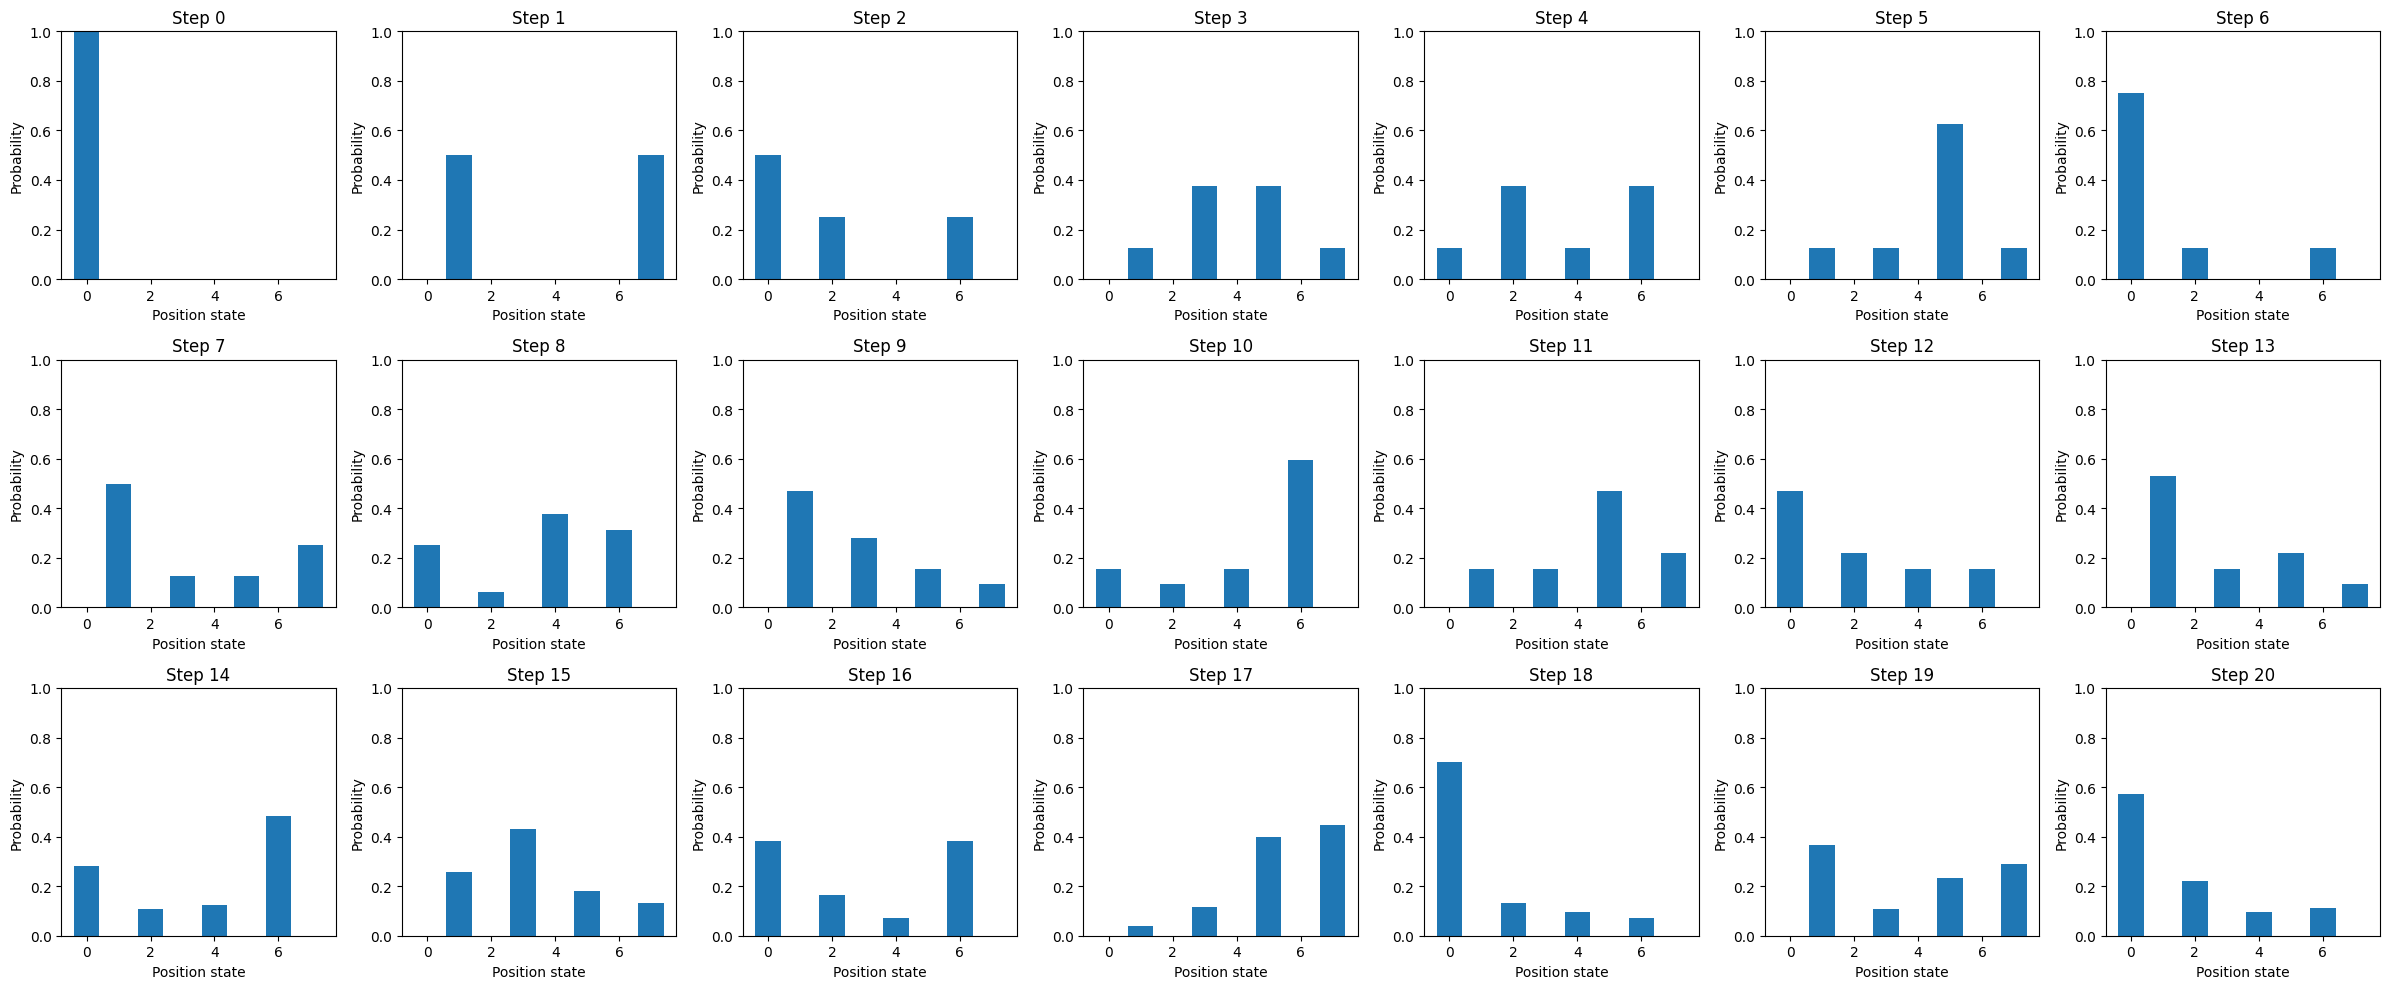

In [140]:
plot_steps(values, 20)

eeh: [np.float64(0.48148888049754507), np.float64(1.6892833111909726e-32), np.float64(0.1956602206627926), np.float64(1.606240295072101e-32), np.float64(0.13742491955051317), np.float64(1.2011669767015196e-32), np.float64(0.18542597928895618), np.float64(2.1682465251738006e-32)], eeeeh: 201


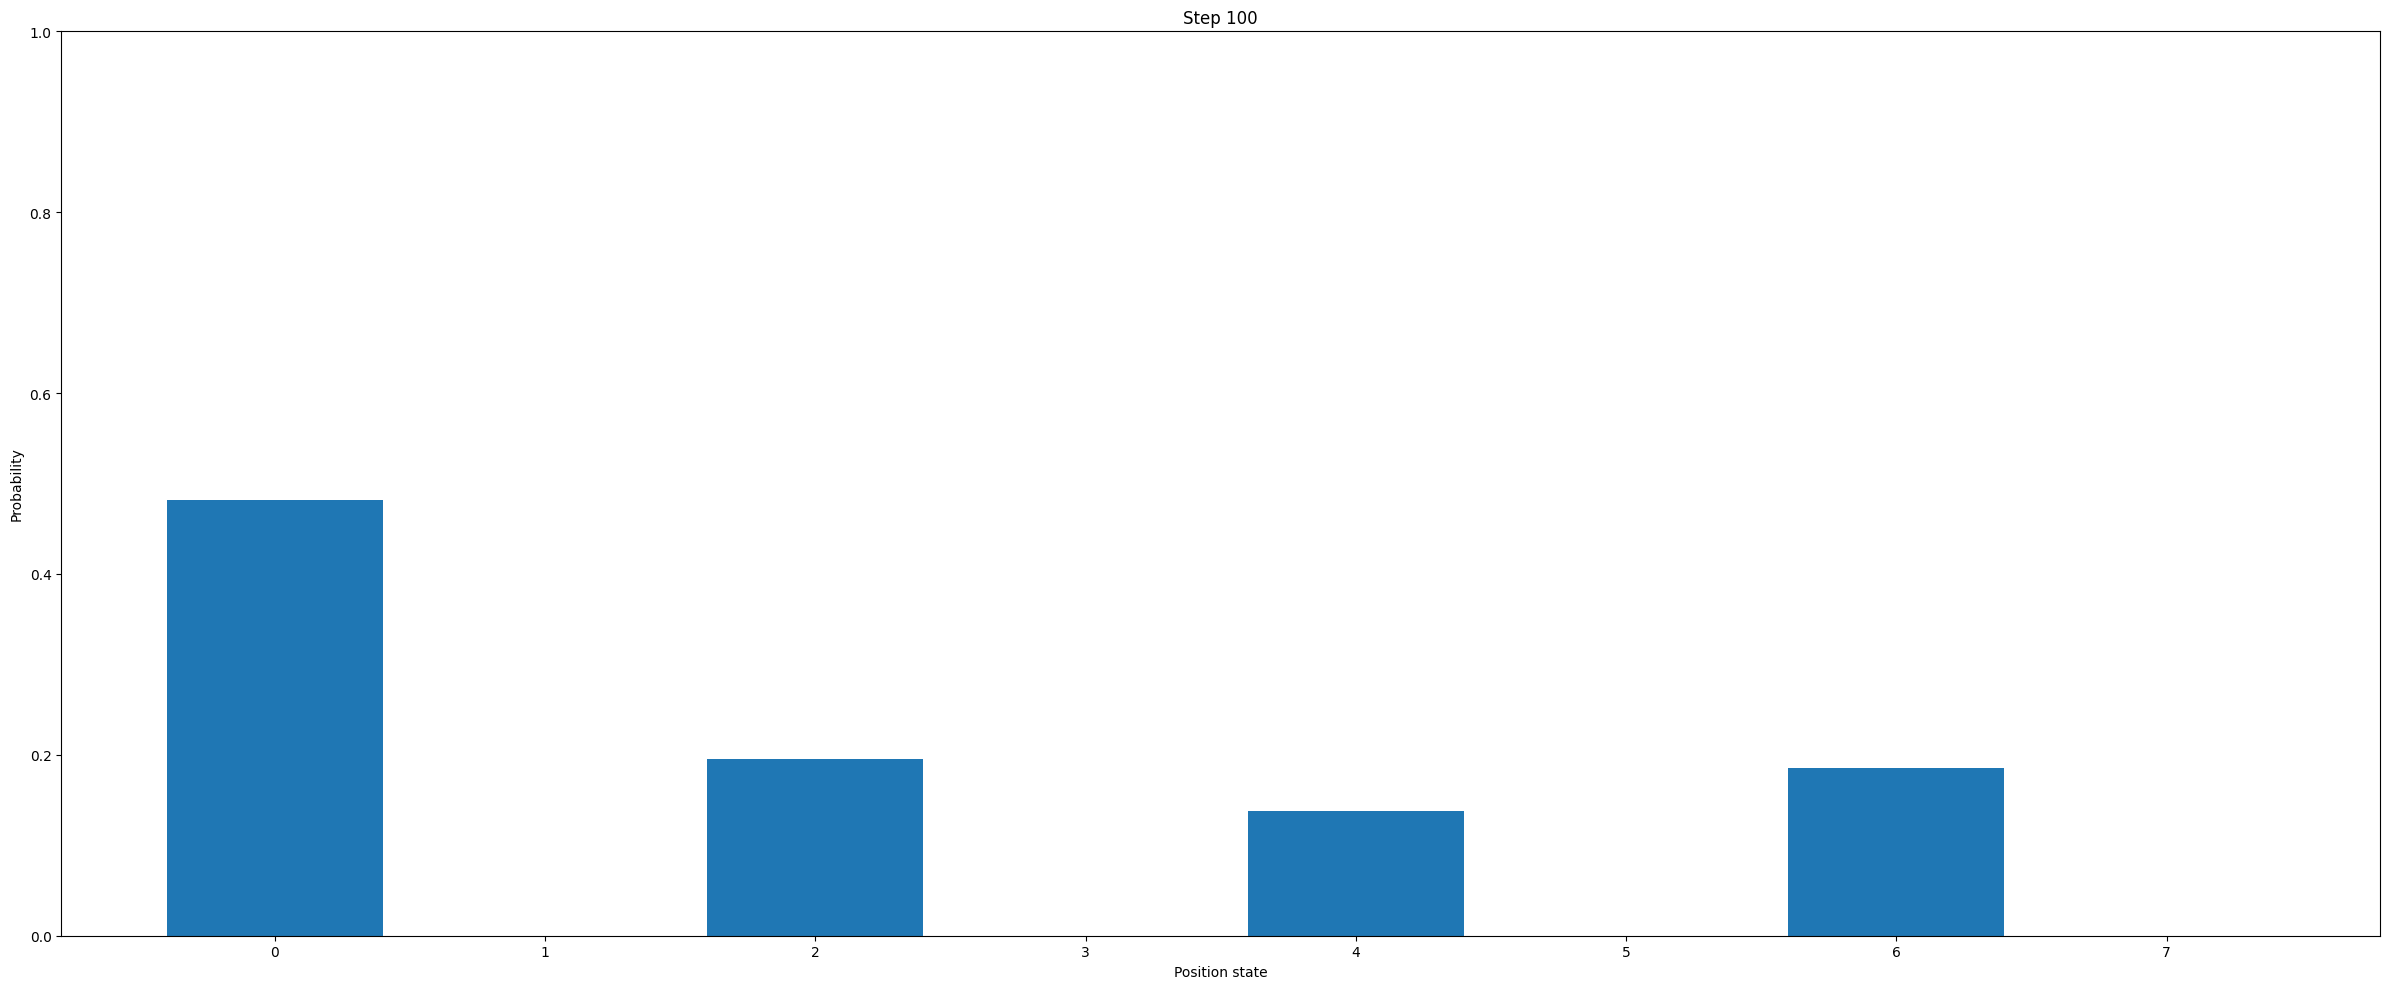

In [84]:
plot_step(values, 100)

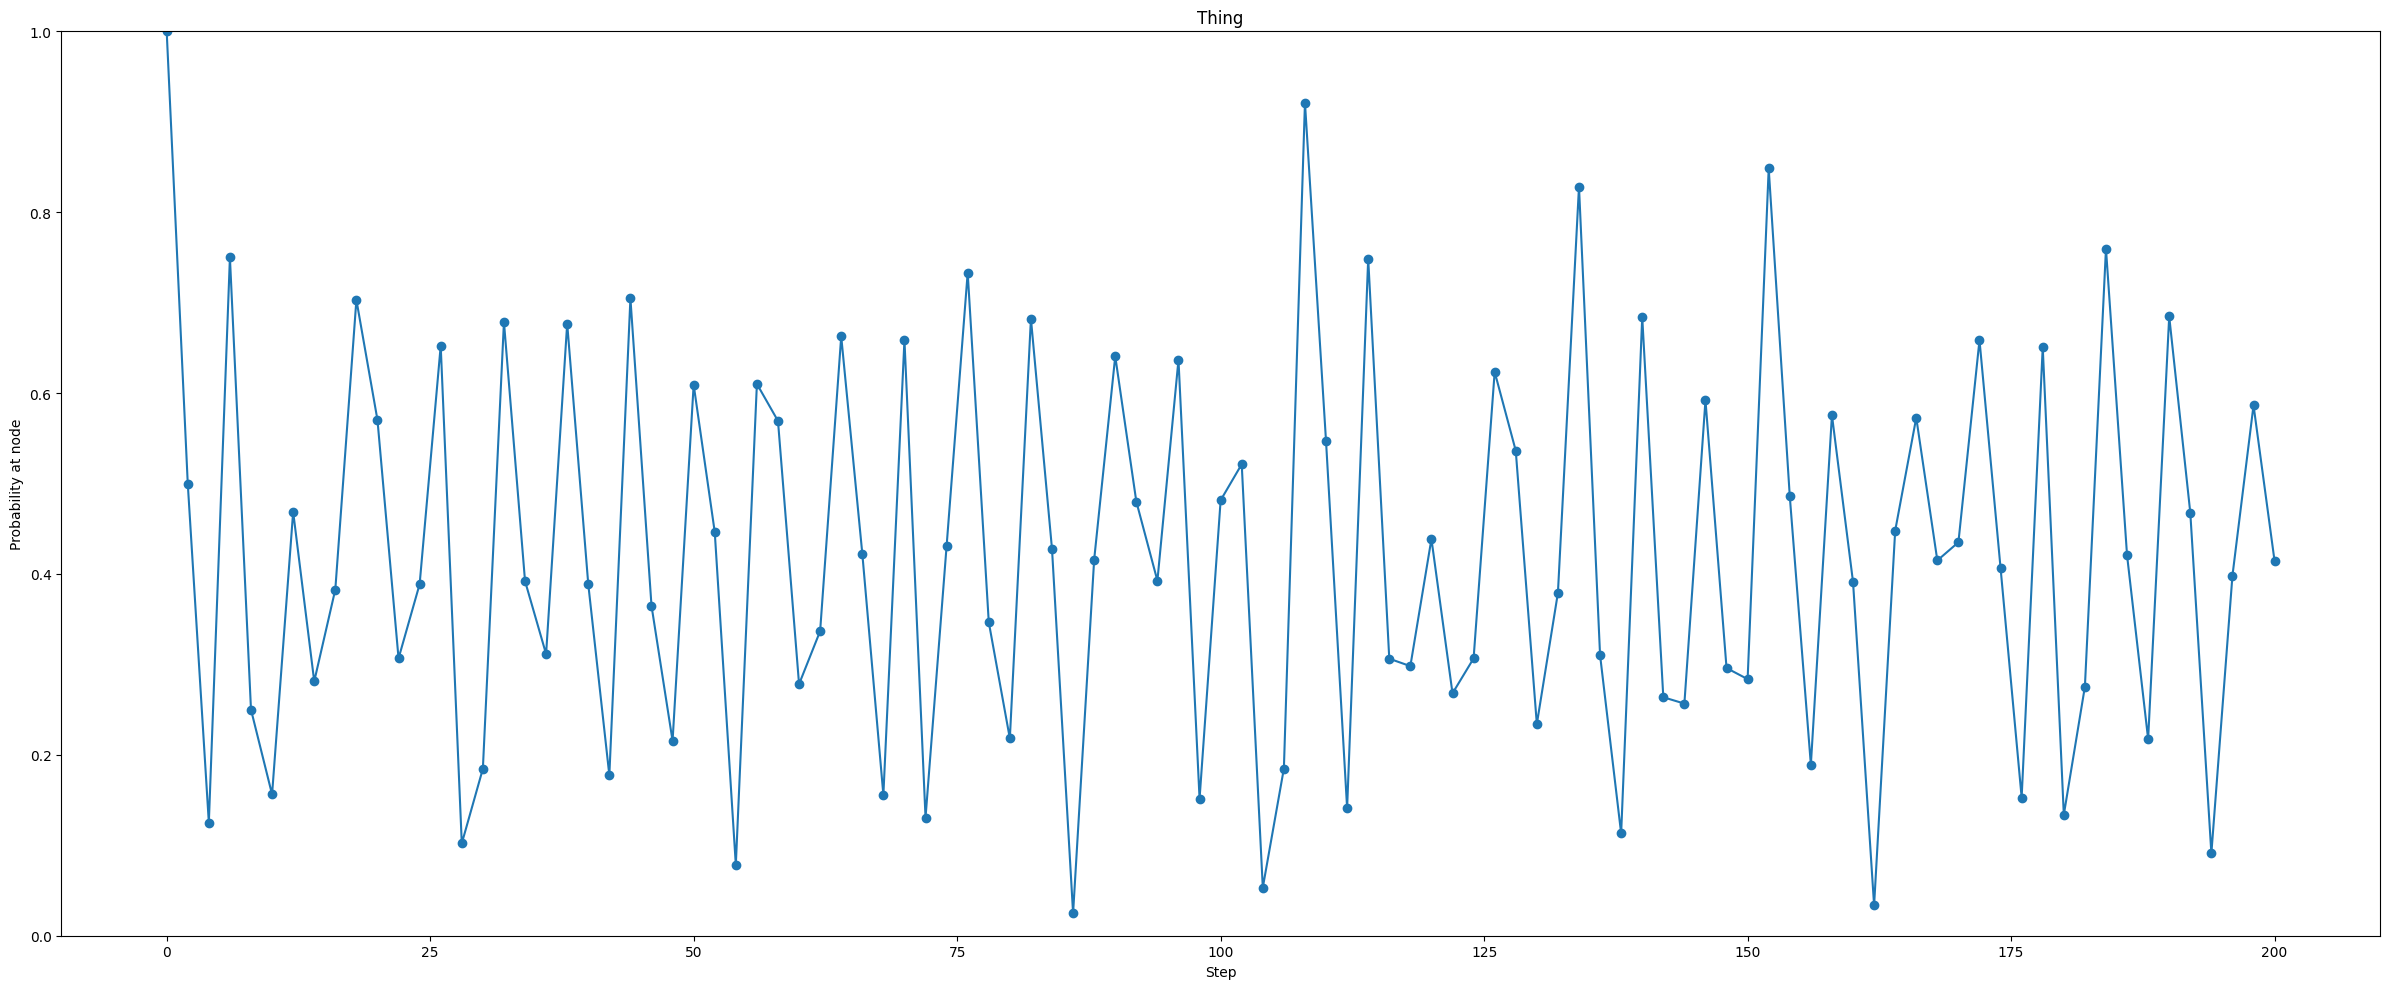

In [136]:
plot_spectral(values, 200, 0)

8


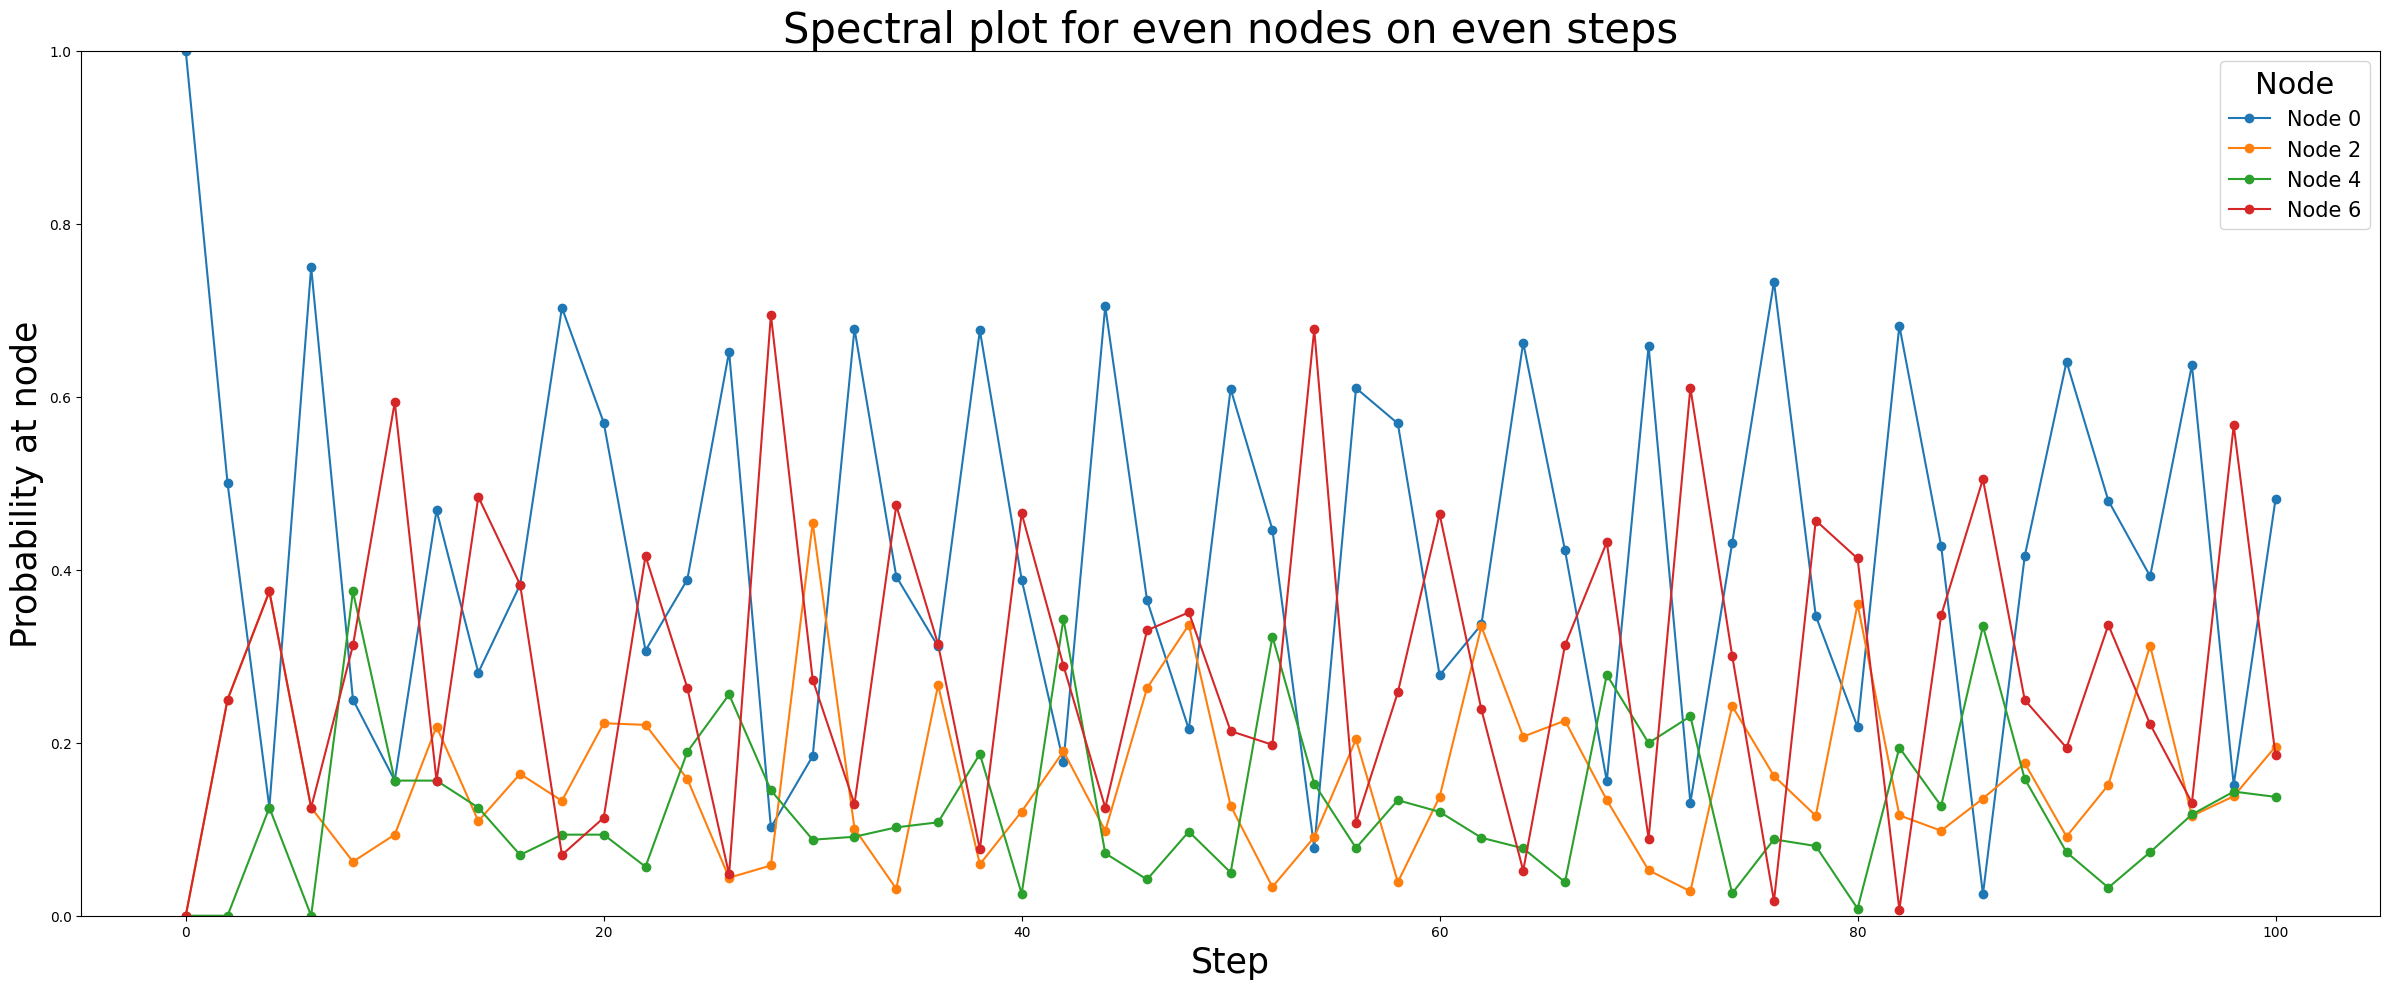

In [157]:
plot_spectral_all(values, 100, 0)

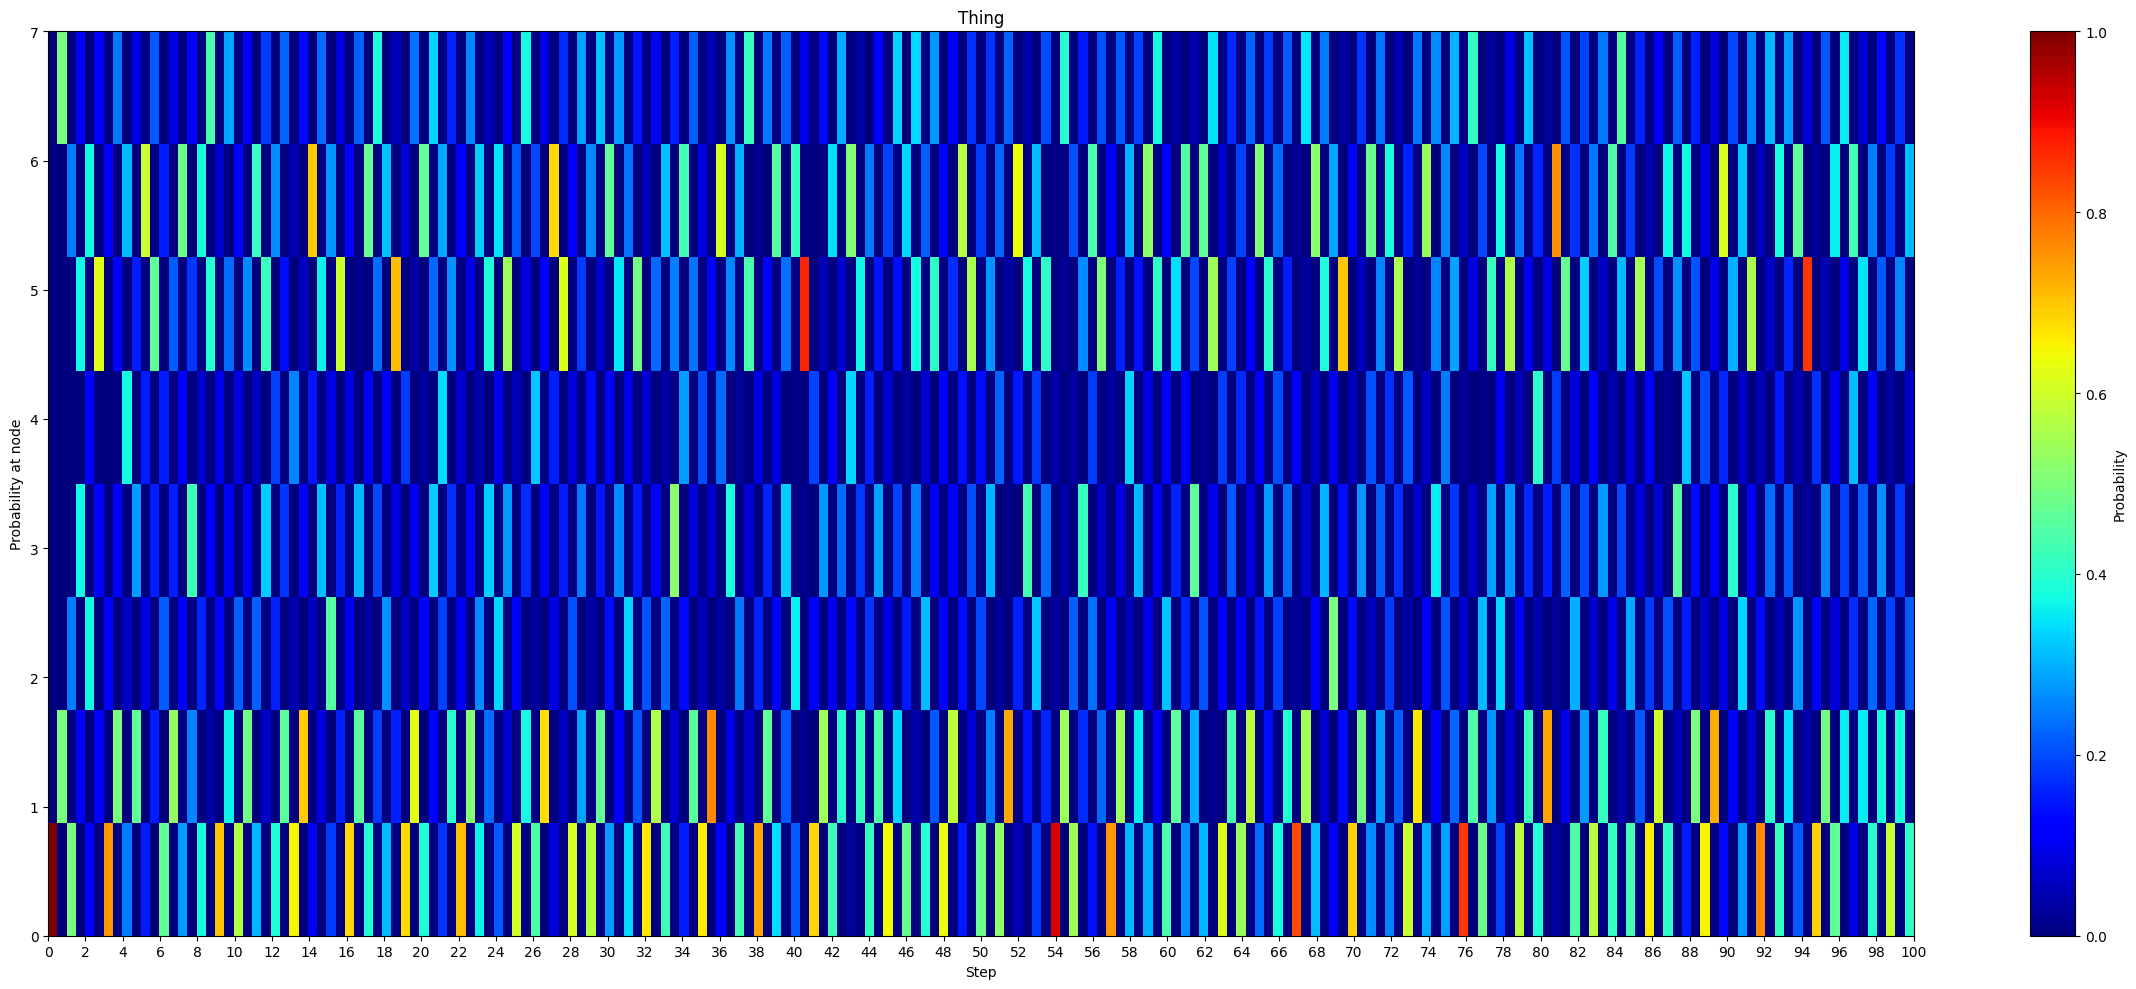

In [ ]:
plot_heat_map(values, 200)